In [3]:
import os
import cv2
import json
import torch
import random
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import mediapipe as mp
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [9]:
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}
label_map = {v: i for i, v in enumerate(emotion_map.values())}

In [10]:
# Face Mesh Setup
mp_face_mesh = mp.solutions.face_mesh # use Face Mesh module
face_mesh = mp_face_mesh.FaceMesh( # landmark grp indices such as FaceMesh_LIPS, FaceMesh_LEFT_EYE etc can also be used
    static_image_mode=True,  # treat each frame image independently
    max_num_faces=1,
    refine_landmarks=True # better precision, especially for iris, lips, nose tip, etc.
) 

I0000 00:00:1750940431.946573   15366 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1750940431.960432   48862 gl_context.cc:344] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.2.8-1ubuntu1~24.04.1), renderer: Mesa Intel(R) UHD Graphics (TGL GT1)


In [11]:
# Extract temporal facial landmark deltas from a video source:

def extract_distance_features(video_path, save_dir="cache"):
    os.makedirs(save_dir, exist_ok=True)
    output_path = os.path.join(save_dir, os.path.basename(video_path) + ".pt") # compute entire output path including filename to store the file, eg: "cache/02-01-03-01-01-01-01.mp4.pt"

    if os.path.exists(output_path): # avoid reprocessing if already processed
        return torch.load(output_path)

    cap = cv2.VideoCapture(video_path) # open video file (.mp4)
    if not cap.isOpened():
        print(f"Could not open video: {video_path}")
        return None

    # Load global reference landmarks once
    if not hasattr(extract_distance_features, "ref_landmarks_global"):
        try:
            extract_distance_features.ref_landmarks_global = np.load("ref_landmarks_global.npy")  # shape: (468, 3)
        except:
            print("ref_landmarks_global.npy not found or corrupted.")
            return None

    ref_landmarks = extract_distance_features.ref_landmarks_global # store the reference landmarks, shape(468, 3)
    norm_factor = np.linalg.norm(ref_landmarks) # a normalization factor = L2 norm of the entire reference landmark matrix.

    valid_deltas = [] # per frame facial deltas stored in this list 
    frame_id = 0
    max_frames = 50
    min_frames_required = 10

    with mp_face_mesh.FaceMesh(
        static_image_mode=False, # consider temporal characteristics such landmark coherence, face similarity, etc
        max_num_faces=1,         # at most 1 face would suffice
        refine_landmarks=True,
        min_detection_confidence=0.3, # detected faces with confidence < 0.3, eliminated
        min_tracking_confidence=0.3
    ) as face_mesh:

        while cap.isOpened() and frame_id < max_frames: # read each frame   
            success, frame = cap.read()
            if not success:
                break

            brightness = np.mean(frame)
            frame_id += 1

            rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # convert to RGB Space
            resized = cv2.resize(rgb, (640, 480))        # resize to 640 x 480 pixels for uniformity
 
            result = face_mesh.process(resized) # pass the frame to FaceMesh model
            if result.multi_face_landmarks:
                landmarks = np.array([[lm.x, lm.y, lm.z] for lm in result.multi_face_landmarks[0].landmark]) # extract x, y, z coordinates of each of the 468 points
                if landmarks.shape[0] >= 468:                                                                # ensure at least 468 landmarks are recorded
                    delta = (landmarks[:468] - ref_landmarks) / norm_factor                                  # compute delta between current landmark and global reference
                    if np.isnan(delta).any():                                                                # if NaN values recorded, skip the frame
                        continue
                    valid_deltas.append(delta) # append to list
                else:
                    print(f"rame {frame_id}: invalid landmark count = {landmarks.shape[0]}")
            else:
                print(f"Frame {frame_id}: brightness {brightness:.2f} | No face detected")

    cap.release()

    if len(valid_deltas) >= min_frames_required: # save deltas for the video iff obtained for enough frames
        final = torch.tensor(np.stack(valid_deltas), dtype=torch.float32)
        torch.save(final, output_path)
        return final
    else:
        print(f"No landmarks extracted from any frame: {video_path}")
        return None

In [12]:
# Filename Parsing Helpers
def get_emotion_label(filename):
    code = filename.split('-')[2]
    return label_map.get(emotion_map.get(code, 'neutral'), 0)

In [13]:
# Build custom dataset from RAVDESS
class RAVDESSDataset(Dataset):
    def __init__(self, samples, max_frames=32):
        self.samples = samples # samples: a list of video_path and corresponding label tuples, eg: (video_path, label)
        self.max_frames = max_frames

    def __len__(self):
        return len(self.samples) # return number of examples in the dataset

    def __getitem__(self, idx):
        path, label = self.samples[idx] # fetch the path and corresponding label at position indicated by idx
        dist_seq = extract_distance_features(path) # extract delta seq form of tensors of shape (T, 468, 3)
        
        if dist_seq is None:
            return None
        
        return dist_seq.view(dist_seq.shape[0], -1), label
#                             no of frames,   flatten from 468, 3 to 1404

In [14]:
# Define Model

"""
Input: seq of frame tensors of shape (T, 1404)
Output: emotion label, after prediction (B, 8)
"""

class DistanceLSTM(nn.Module): # create a pyTorch NN
    def __init__(self, input_size=1404, hidden_size=64, num_classes=8): # 64 hidden units per layer, 8 emotion categories
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=128, kernel_size=3, padding=1) # consider three frames (n-1, n, n+1) over the time axis and apply convolution, reduces memory load and smoothening of noise can be achieved without compressing imp data
        self.lstm = nn.LSTM(input_size=128, hidden_size=64, num_layers=2, batch_first=True)
        self.dropout = nn.Dropout(0.3)  # Dropout added to prevent overfitting
        self.fc = nn.Linear(64, num_classes) # 64 dim to 8 dim

    def forward(self, x):
        x = x.transpose(1, 2)         # (B, T, 1404) → (B, 128 T), to apply convolution over time axis for all 1404 features instead of features axis
        x = self.conv1(x)             # (B, F, T) → (B, 128, T), 1404 compresses to 128
        x = x.transpose(1, 2)         # (B, 128, T) → (B, T, 128), revert it back
        out, _ = self.lstm(x)         # (B, T, 128) → (B, T, 64)
        out = self.dropout(out[:, -1, :])
        return self.fc(out)           # (B, 64) → (B, num_classes)

In [15]:
def collate_skip_none(batch):
    batch = [b for b in batch if b is not None] # remove none
    if not batch:
        return None # if no face is detected
    return torch.utils.data.dataloader.default_collate(batch)

def train(model, dataloader, optimizer, criterion, device):
    model.train() # model is switched to training mode
    
    total_loss = 0 # initialized to accumulate loss across batches
    
    for batch in dataloader:
        if batch is None: # skip if none
            continue
        
        X, y = batch # X shape = (B, T, 1404), y shape = (B,)
        X, y = X.to(device), y.to(device)
        
        optimizer.zero_grad() # clr old gradients
        out = model(X)
        loss = criterion(out, y) # cross entropy is used
        loss.backward() # compute grad using backward propogation
        optimizer.step() # update weights using computed grad
        total_loss += loss.item()
        
    return total_loss / len(dataloader) # avg loss per batch

def evaluate(model, dataloader, device):
    model.eval() # put the model to eval mode, disables dropout and batchnorm updates
    correct = total = 0 # initialize coutners
    
    with torch.no_grad(): # disable grad tracking
        for batch in dataloader:
            if batch is None:
                continue
            
            X, y = batch
            X, y = X.to(device), y.to(device)
            
            out = model(X) # forward pass
            pred = torch.argmax(out, dim=1) # class index with highest score
            
            correct += (pred == y).sum().item()
            total += y.size(0)
            
    return correct / total if total > 0 else 0.0 # return accuracy


In [16]:
# plot confusion matirx:

def plot_confusion_matrix(model, dataloader, device, label_map):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            output = model(X)
            pred = torch.argmax(output, dim=1).cpu().numpy()
            y_pred.extend(pred)
            y_true.extend(y.numpy())

    cm = confusion_matrix(y_true, y_pred)
    labels = list(label_map.keys())
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()

In [22]:
def run_training_pipeline():
    root = "/home/sabharishhh/Code/ML/dataset/"
    emotion_folders = sorted(os.listdir(root)) # emotion class names
    
    global label_map     # create label map
    label_map = {emotion: idx for idx, emotion in enumerate(emotion_folders)}

    train_list = []
    test_list = []

    for emotion in emotion_folders:
        folder = os.path.join(root, emotion)
        videos = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".mp4")]
        random.shuffle(videos) # ensures different actors go into train/test operation

        split_idx = int(0.8 * len(videos))  # for 80-20 split
        train_videos = videos[:split_idx]
        test_videos = videos[split_idx:]

        train_list.extend([(v, label_map[emotion]) for v in train_videos]) # a list of tuples, ie., [(video_path_1, label_1), (video_path_2, label_2), ....]
        test_list.extend([(v, label_map[emotion]) for v in test_videos])

    # Dataset and DataLoader setup
    train_set = RAVDESSDataset(train_list) # returns (T, 1404) vectors
    test_set = RAVDESSDataset(test_list)
    
    train_loader = DataLoader(train_set, batch_size=16, shuffle=True, collate_fn=collate_skip_none)
    test_loader = DataLoader(test_set, batch_size=16, shuffle=False, collate_fn=collate_skip_none)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = DistanceLSTM(input_size=1404, hidden_size=64, num_classes=len(label_map)).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # learning rate = 0.001

    # Weighted Loss
    y_train_labels = [label for _, label in train_list]
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_labels), y=y_train_labels)
    weight_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
    criterion = torch.nn.CrossEntropyLoss(weight=weight_tensor)

    # Training loop
    best_test_acc = 0.0
    for epoch in range(1, 101):
        loss = train(model, train_loader, optimizer, criterion, device)
        train_acc = evaluate(model, train_loader, device)
        test_acc = evaluate(model, test_loader, device)
        print(f"Epoch {epoch:02d} | Loss: {loss:.4f} | Train Acc: {train_acc:.2%} | Test Acc: {test_acc:.2%}")

        if test_acc > best_test_acc:
            best_test_acc = test_acc
            torch.save(model.state_dict(), "best_model.pt")
        
        if test_acc >= 0.93:
            print(f"Early stopping: Test accuracy reached {test_acc:.2%} at epoch {epoch}.")
            break
        
    # Save final model
    save_path = "/home/sabharishhh/Code/ML/Model"
    os.makedirs(save_path, exist_ok=True)
    torch.save(model.state_dict(), os.path.join(save_path, "emotion_lstm_model.pth"))
    with open(os.path.join(save_path, "emotion_lstm_labels.json"), "w") as f:
        json.dump(label_map, f)

    plot_confusion_matrix(model, test_loader, device, label_map)


In [18]:

# Root folder for sorted dataset
root = "/home/sabharishhh/Code/ML/dataset/"
emotion_folders = sorted(os.listdir(root))

# Create label map
label_map = {emotion: idx for idx, emotion in enumerate(emotion_folders)}

# Prepare train/test split
train_list = []
test_list = []

for emotion in emotion_folders:
    folder_path = os.path.join(root, emotion)
    video_files = [f for f in os.listdir(folder_path) if f.endswith(".mp4")]
    video_paths = [os.path.join(folder_path, f) for f in video_files]
    random.shuffle(video_paths)

    split_idx = int(0.8 * len(video_paths))
    train_list += [(p, label_map[emotion]) for p in video_paths[:split_idx]]
    test_list += [(p, label_map[emotion]) for p in video_paths[split_idx:]]

# Cache directory
os.makedirs("cache", exist_ok=True)
cached = set(os.path.basename(f) for f in os.listdir("cache"))

# Filter files that are not yet cached
remaining = [(p, l) for (p, l) in train_list + test_list if os.path.basename(p) + ".pt" not in cached]

print(f"⏳ Resuming — {len(remaining)} videos left to cache")

for path, _ in tqdm(remaining):
    _ = extract_distance_features(path)


⏳ Resuming — 360 videos left to cache


  0%|          | 0/360 [00:00<?, ?it/s]I0000 00:00:1750940446.823686   15366 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1750940446.825851   49284 gl_context.cc:344] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.2.8-1ubuntu1~24.04.1), renderer: Mesa Intel(R) UHD Graphics (TGL GT1)
  0%|          | 1/360 [00:01<06:56,  1.16s/it]I0000 00:00:1750940447.899847   15366 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1750940447.901968   49326 gl_context.cc:344] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.2.8-1ubuntu1~24.04.1), renderer: Mesa Intel(R) UHD Graphics (TGL GT1)
  1%|          | 2/360 [00:01<05:11,  1.15it/s]I0000 00:00:1750940448.571558   15366 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1750940448.573459   49375 gl_context.cc:344] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.2.8-1ubuntu1~24.04.1), renderer: Mesa Intel(R) UHD Graphics (TGL GT1)
  1%|          | 3/360 [00:02<04:28,  1.33

In [6]:
# Load the face mesh model
mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils
mp_style = mp.solutions.drawing_styles

# Input and output paths
video_path = "/home/sabharishhh/Code/ML/dataset/angry/01-01-05-01-01-01-01.mp4"
output_dir = "mesh_frames_output"
os.makedirs(output_dir, exist_ok=True)

# Open video
cap = cv2.VideoCapture(video_path)
frame_idx = 0
saved_count = 0

with mp_face_mesh.FaceMesh(
    static_image_mode=False,
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
) as face_mesh:

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Convert frame to RGB
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(rgb_frame)

        if results.multi_face_landmarks:
            # Draw mesh on the face
            annotated_frame = frame.copy()
            for landmarks in results.multi_face_landmarks:
                custom_spec = mp_drawing.DrawingSpec(color=(33, 222, 255), thickness=1, circle_radius=1)  # Blue lines

                mp_drawing.draw_landmarks(
                    image=annotated_frame,
                    landmark_list=landmarks,
                    connections=mp_face_mesh.FACEMESH_TESSELATION,
                    landmark_drawing_spec=None,
                    connection_drawing_spec=custom_spec,
                )

            # Save every Nth frame (optional)
            if frame_idx % 25 == 0:
                output_path = os.path.join(output_dir, f"mesh_frame_{frame_idx}.png")
                cv2.imwrite(output_path, annotated_frame)
                saved_count += 1

        frame_idx += 1

cap.release()
print(f"✅ Saved {saved_count} mesh frames to {output_dir}")


I0000 00:00:1750939086.324484   15366 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1750939086.327036   17196 gl_context.cc:344] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.2.8-1ubuntu1~24.04.1), renderer: Mesa Intel(R) UHD Graphics (TGL GT1)


✅ Saved 5 mesh frames to mesh_frames_output


Epoch 01 | Loss: 1.9912 | Train Acc: 21.33% | Test Acc: 19.72%
Epoch 02 | Loss: 1.9330 | Train Acc: 22.42% | Test Acc: 20.76%
Epoch 03 | Loss: 1.8937 | Train Acc: 21.20% | Test Acc: 18.69%
Epoch 04 | Loss: 1.7785 | Train Acc: 32.54% | Test Acc: 29.24%
Epoch 05 | Loss: 1.7523 | Train Acc: 31.10% | Test Acc: 28.55%
Epoch 06 | Loss: 1.7092 | Train Acc: 31.28% | Test Acc: 30.80%
Epoch 07 | Loss: 1.6249 | Train Acc: 39.49% | Test Acc: 34.95%
Epoch 08 | Loss: 1.5915 | Train Acc: 35.71% | Test Acc: 33.74%
Epoch 09 | Loss: 1.5474 | Train Acc: 40.83% | Test Acc: 36.16%
Epoch 10 | Loss: 1.5475 | Train Acc: 43.14% | Test Acc: 39.45%
Epoch 11 | Loss: 1.4978 | Train Acc: 43.35% | Test Acc: 40.31%
Epoch 12 | Loss: 1.4312 | Train Acc: 47.96% | Test Acc: 42.91%
Epoch 13 | Loss: 1.3957 | Train Acc: 49.17% | Test Acc: 43.60%
Epoch 14 | Loss: 1.4066 | Train Acc: 48.31% | Test Acc: 43.94%
Epoch 15 | Loss: 1.2788 | Train Acc: 53.34% | Test Acc: 45.33%
Epoch 16 | Loss: 1.2486 | Train Acc: 54.78% | Test Acc:

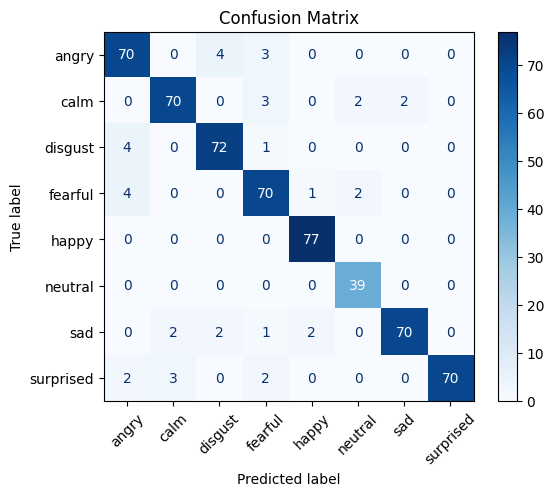

In [24]:
# Step 12: Run Training
run_training_pipeline()

In [31]:
def predict_expression(video_path, max_frames=32):
    with open("/home/sabharishhh/Code/ML/Model/emotion_lstm_labels.json") as f:
        label_map = json.load(f)
    inv_map = {v: k for k, v in label_map.items()}
    model = DistanceLSTM(input_size=468, hidden_size=64, num_classes=len(label_map))
    model.load_state_dict(torch.load("/home/sabharishhh/Code/Machine Learning/emotion_lstm_model.pth", map_location=torch.device('cpu')))
    model.eval()
    with torch.no_grad():
        x = extract_distance_features(video_path, max_frames=max_frames, visualize=True)
        if x is None:
            return "No face detected"
        x = x.unsqueeze(0)
        out = model(x)
        pred = torch.argmax(out, dim=1).item()
        return inv_map[pred]

In [ ]:

# Example:
result = predict_expression("/home/sabharishhh/Code/ML/dataset/02-01-06-01-01-01-01.mp4")
print("Predicted Emotion:", result)
